과제: 파이썬 머신러닝 완벽 가이드 ch8.10

마감: 5월 3일 금요일 18:30

pg. 544~561 필사하여 깃허브 주소를 댓글로 남겨주세요.

# Chap8. 텍스트 분석

## 8-10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

### 데이터 전처리

In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('./data/mercari-price-suggestion-challenge/mercari_train.tsv', sep = '\t')
print(mercari_df.shape)

(1482535, 8)


In [2]:
mercari_df.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [3]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name 칼럼에 null 값이 많다. 
- category_name 칼럼은 6300건 정도의 null 데이터가 있다.
- item_description은 4개 정도의 null 데이터가 있다.

-----------
#### target : price 칼럼

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_20544\965257802.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde = False)


<AxesSubplot:xlabel='price'>

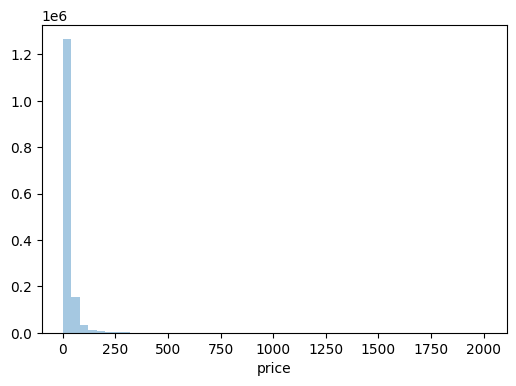

In [4]:
# target 값인 price 칼럼의 데이터 분포도 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6, 4))
sns.distplot(y_train_df, kde = False)

<AxesSubplot:xlabel='price', ylabel='Count'>

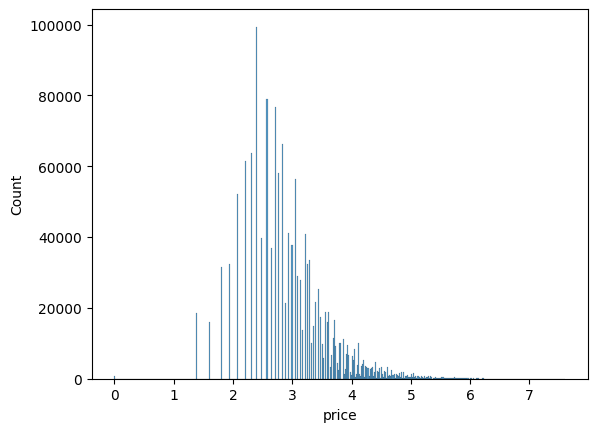

In [5]:
# price 값이 바교적 적은 가격에 왜곡되어 분포되어 있다.
# log transformation을 취한 뒤 다시 확인
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, kde = False)

price 값이 비교적 정규분포에 가까워졌다. 

In [6]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

---------
#### shipping 칼럼, item_condition_id 칼럼

In [7]:
print('Shipping 값 유형 : \n', mercari_df['shipping'].value_counts(),'\n\n')
print('item_condition_id 값 유형 : \n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형 : 
 0    819435
1    663100
Name: shipping, dtype: int64 


item_condition_id 값 유형 : 
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


- shipping : 값이 비교적 균일
- item_condition_id : 1, 2, 3이 주를 이룬다. description이 없는 경우 'No description yet'으로 되어 있다.

In [8]:
# 'item_description'칼럼의 No description yet을 살펴보자
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

----------
#### category_name 칼럼

'/'로 분리된 카테고리를 하나의 문자열로 나타내고 있다. 여기서는 category_name의 '/'를 기준으로 단어를 토큰화하여 별도의 피처로 저장하고 이를 이용하여 알고리즘을 학습시킨다.

category_name 칼럼을 '/' 기준으로 대, 중, 소분류를 효과적으로 분리해내기 위해 별도의 split_cat() 함수를 생성하고 이를 apply lambda로 적용한다.

- null이 아닌 경우에는 split('/')을 이용해 대, 중, 소분류로 분리한다. 이는 리스트로 반환된다.
- null인 경우에는 split함수가 error를 발생하므로 이 error를 except catch하여 대, 중, 소분류 모두 'Other Null'값을 부여한다.
- 대, 중, 소 칼럼은 mercari_df에서 cat_dae, cat_jung, cat_so로 부여한다.
- pandas의 apply lambda로 반환되는 데이터 세트가 리스트를 요소로 갖고 있는데, 이것을 여러 칼럼으로 분류하는 것이 문제다. >> zip, *를 apply lambda식으로 분리한다

In [9]:
mercari_df['category_name'].head(10)

0                                    Men/Tops/T-shirts
1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
5                                    Women/Other/Other
6                             Women/Swimwear/Two-Piece
7                      Sports & Outdoors/Apparel/Girls
8                      Sports & Outdoors/Apparel/Girls
9             Vintage & Collectibles/Collectibles/Doll
Name: category_name, dtype: object

In [10]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성
# 대, 중, 소 값을 리스트로 반환

def split_cat(category_name):
    try :
        return category_name.split('/')
    except :
        return ['Other_Null', 'Other_Null', 'Other_Null']
    

# 위의 split_cat()을 apply_lambda에서 호출해 대, 중, 소 칼럼을 mercar9_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

In [11]:
# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출

print('대분류 유형 : \n\n', mercari_df['cat_dae'].value_counts(), '\n\n')
print('중분류 개수 : ', mercari_df['cat_jung'].nunique(), '\n\n')
print('소분류 개수 : ', mercari_df['cat_so'].nunique())

대분류 유형 : 

 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64 


중분류 개수 :  114 


소분류 개수 :  871


----
#### 결측치 처리
brand_name, category_name, item_description 칼럼의 null은 일괄적으로 'Other Null'로 변경

In [12]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value = 'Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value = 'Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value = 'Other_Null')

# 각 칼럼별로 Null 값 건수 확인, 모두 0이 나와야 한다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

---------
### 피처 인코딩과 피처 벡터화

문자열 칼럼이 많으므로 이 중 레이블 인코딩 또는 원핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별해보자. 먼저 이 피처를 어떤 방식으로 변환할지 검토한 후에 일괄적으로 변환작업을 수행하자.

Mercari Price Suggestion에서 예측 모델은 price 값, 즉 상품 가격을 예측해야 하므로 회귀 모델을 기반으로 한다. 선형 회귀 모델과 회귀 트리 모델을 모두 적용할 예정이다.
- 선형 회귀 : 원-핫 인코딩 적용이 훨씬 선호되므로 이때 인코딩할 피처는 모두 원-핫 인코딩을 적용한다.
- 피처 벡터화 : 비교적 짧은 텍스트는 Count 기반의 벡터화를, 긴 텍스트는 TF-IDF 기반의 벡터화를 적용한다.

----------
#### brand_name
유형 건수와 대표 브랜드 5개만 알아보자

In [13]:
print('brand name의 유형 건수 : ', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 :  4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


brand_name의 경우 대부분 명료한 문자열로 되어 있어 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환을 적용하면 된다. 4810건으로 원-핫 인코딩 변환하기엔 다소 많아보이나 ML 모델 구축상 큰 문제는 없다. 

------
#### name : 상품명
어떤 유형으로 되어 있는지 유형 건수와 상품명을 7개만 추출해본다.

In [14]:
print('name의 종류 개수 : ', mercari_df['name'].nunique())
print('name sample 10건 : \n', mercari_df['name'][:10])

name의 종류 개수 :  1225273
name sample 10건 : 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


유형이 매우 많고, 적은 단어 위주위 텍스트 형태로 되어 있으므로 Count 기반으로 피처 벡터화 변환을 적용한다.

- category_name : 이전의 전처리를 통해 대분류, 중분류, 소분류인 cat_dae, cat_jung, cat_so로 분리되었다. 이 세 칼럼도 원-핫 인코딩을 적용한다.
- shipping : 배송비 무료 여부로, 0과 1 두 유형의 값을 갖는다. 원-핫 인코딩을 적용한다.
- item_condition_id : 상품 상태로, 1-5까지 5개의 유형의 값을 갖는다. 원-핫 인코딩을 적용한다.
- item_description : 상품에 대한 간단한 설명, 데이터셋에서 가장 긴 텍스트를 갖는다. 칼럼의 평균 문자열 크기와 텍스트 2개만 추출해보자.

In [16]:
pd.set_option('max_colwidth', 200)

# item_description 평균 문자열 크기
print('item_description 평균 문자열 크기 : ', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기 :  145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

평균 문자열이 145자로 비교적 크므로, TF-IDF로 변환한다.

------

#### 주요 칼럼 인코딩 및 피처 벡터화
- name : CountVectorizer로 피처 벡터화 (기본 파라미터)
- item_description : TfidfVectorizer로 피처 벡터화 (max_features = 50000, n_gram = (1, 3), stop_words = english)

In [17]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words = 'english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape : ', X_name.shape)
print('item_description vectorization shape : ', X_descp.shape)

name vectorization shape :  (1482535, 105757)
item_description vectorization shape :  (1482535, 50000)


-----
CountVectorizer, TfidfVectorizer가 fit_transform을 통해 반환하는 데이터는 희소 행렬 형태이다. 희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 뎅터 세트로 구성해야 하며, 앞으로 인코딩될 칼럼들도 모두 X_name, X_descp와 결합되어 ML 모델을 실행하는 기반 데이터 세트로 재구성되어야 한다.

이를 위해 다음과 같은 과정을 거친다. 
1. 이 인코딩 대상 칼럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤, 함께 결합한다.
2. LabelBinarizer 클래스는 희소 행렬 형태의 원-핫 인코딩 변환을 지원한다. 생성시 sparse_out = True로 파라미터를 설정해주면 된다.
3. 개별 칼럼으로 만들어진 희소 행렬은 scipy 패키지 sparse 모듈의 hstack()함수를 이용해 결합한다. hstack()함수는 희소 행렬을 손쉽게 칼럼 레벨로 결합할 수 있게 해준다.

1. 인코딩 대상 칼럼을 모두 LabelBinarizer로 원-핫 인코딩 변환한다

In [18]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output = True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output = True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output = True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output = True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df["cat_dae"])
lb_cat_jung = LabelBinarizer(sparse_output = True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df["cat_jung"])
lb_cat_so = LabelBinarizer(sparse_output = True)
X_cat_so = lb_cat_so.fit_transform(mercari_df["cat_so"])

제대로 변환되었는지 생성된 인코딩 데이터 세트를 살펴본다.

In [19]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print("X_brand shape : {0}, X_item_cond_id shape : {1}".format(X_brand.shape, X_item_cond_id.shape))
print("X_shipping shape : {0}, X_cat_dae shape : {1}".format(X_shipping.shape, X_cat_dae.shape))
print("X_cat_jung shape: {0}, X_cat_so shape : {1}".format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape : (1482535, 4810), X_item_cond_id shape : (1482535, 5)
X_shipping shape : (1482535, 1), X_cat_dae shape : (1482535, 11)
X_cat_jung shape: (1482535, 114), X_cat_so shape : (1482535, 871)


- 인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입이다. 
- brand_name 칼럼의 경우 유형이 4810개이므로 이를 원-핫 인코딩으로 변환한 X_brand_shape의 경우 4810개의 인코딩 칼럼을 가지게 되었다.
- 인코딩 칼럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 경우 매우 많은 칼럼과 함께 결합되므로 크게 문제 되지는 않는다.

2. hstack()으로 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 결합한다.
만들어진 결합 데이터가 비교적 많은 메모리를 잡아먹기 때문에 del과 gc.collect()으로 결합한 데이터를 메모리에서 삭제한다.

In [20]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, 
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


166

------
### 릿지 회귀 모델 구축 및 평가
이제 이렇게 만들어진 데이터 세트에 회귀를 적용해 price 값을 예측하는 모델을 만들자.

#### 로직 함수화
여러 알고리즘 모델과 희소 행렬을 변환하고 예측 성능을 비교하면서 수행할 것이므로 수행에 필요한 로직을 함수화한다.
1. 모델을 평가하는 평가(Evaluation) 로직 함수화 : RMSLE 사용
2. RMSLE를 구하는 함수 : price값을 다시 지수 변환을 통해 원복해야하는 것 유의
3. evaluate_org_price(y_test, y_pred)함수 : 원복된 데이터를 기반으로 RMSLE 적용하는 함수

In [21]:
def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2) ))

In [22]:
def evaluate_org_price(y_test, preds):

    # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [23]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list).tocsr()
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df["price"],
                                                       test_size=0.2, random_state=156)
    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

----------

Ridge를 이용해 Mercari Price의 회귀 예측 수행

예측 수행 전에 Mercari 상품 가격 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 확인해본다

In [24]:
# item_description 속성의 피처 벡터화 데이터가 포함되지 않았을 때의 예측 성능
linear_model = Ridge(solver = "lsqr", fit_intercept = False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, 
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print("Item Description을 제외했을 때 rmsle 값 : ", evaluate_org_price(y_test, linear_preds))

# item_description 속성의 피처 벡터화 데이터가 포함되었을 때의 예측 성능
sparse_matrix_list = (X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)

print("Item Description을 포함했을 때 rmsle 값:", evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값 :  0.498426733103894
Item Description을 포함했을 때 rmsle 값: 0.5109085551253141


--------
### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

LGBM을 이용해 회귀를 수행한 뒤, 위에서 구한 릿지 모델 예측값과 LGBM 모델 예측값을 간단한 앙상블 방식으로 섞어서 최종 회귀 예측값을 평가하자

In [25]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators = 100, learning_rate = 0.5, num_leaves = 125, random_state=156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)
print("LightGBM rmsle 값 : ", evaluate_org_price(y_test, lgbm_preds))

LightGBM rmsle 값 :  0.5008074618917219


In [26]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55

print("LightGBM과 Ridge를 ensemble한 최종 rmsle 값 : ", evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값 :  0.4937656982768922
